In [7]:
import pandas as pd
import numpy as np
import os
import copy
from sklearn.decomposition import PCA
import pyecharts

In [2]:
base_dir = r"D:\A\Desktop\StudyFlow\比赛\游戏玩家付费金额预测大赛\tap4fun竞赛数据\tap4fun竞赛数据"

## 1. 查看是否有重复数据

In [3]:
data = pd.read_csv(os.path.join(base_dir, "tap_fun_train.csv"), parse_dates=True)
data_test = pd.read_csv(os.path.join(base_dir, "tap_fun_test.csv"), parse_dates=True)

# 提取user_id列，并做合并处理
data_id = pd.DataFrame(data['user_id'],columns=['user_id'])
data_test_id = pd.DataFrame(data_test['user_id'],columns=['user_id'])
pd.merge(data_id, data_test_id, on = 'user_id')

,user_id


## 2. 玩家注册时间分布

In [8]:
# 增加两列
data['register_time_month'] = data.register_time.str[:7]
data['register_time_day'] = data.register_time.str[6:10]

# 统计并保存为dataframe
data_month_df = pd.DataFrame(data['register_time_month'].value_counts()).sort_index()
# print(data_month_df)
data_day_df = pd.DataFrame(data['register_time_day'].value_counts()).sort_index()
# print(data_day_df)

# 画图  用了echarts的python版，挺好用的，也美观
from pyecharts import Line, Grid

line1 = Line("玩家数量统计-月")
line1.add("玩家数量", data_month_df.index, data_month_df['register_time_month'], mark_line=["average"], mark_point=["max", "min"])

line2 = Line("玩家数量统计-日",title_top="50%")
line2.add("玩家数量", data_day_df.index, data_day_df['register_time_day'], mark_line=["average"], mark_point=["max", "min"])

grid = Grid(width = 1000, height = 1000)
grid.add(line1, grid_bottom="60%")
grid.add(line2, grid_top="60%")
grid.render()

grid

## 3. 有多少付费玩家，比例随时间的变化，会给多少钱，分布如何？

In [9]:
data_pay_7 = copy.copy(data[data['pay_price']>0])
print(data_pay_7.shape)   # (41439, 111)
print(data_pay_7.shape[0]/data.shape[0])  # 0.018111395638212645

(41439, 111)
0.018111395638212645


## 4. 付费玩家比例随时间的变化

In [10]:
# ----------------------------- 统计，改列明（避免冲突），合并，计算比例
data_pay_7_day_df = pd.DataFrame(data_pay_7['register_time_day'].value_counts()).sort_index()
# print(data_pay_7_day_df)
data_pay_7_day_df.rename(columns={'register_time_day':'pay_register_time_day'}, inplace = True)
data_day_count = pd.concat([data_pay_7_day_df, data_day_df], axis=1)
# print(data_day_count)
data_day_count['pay_percent'] = data_day_count['pay_register_time_day']/data_day_count['register_time_day']
# print(data_day_count)

# ----------------------------- 画图
from pyecharts import Overlap

line3 = Line()
line3.add("注册玩家数量", data_day_count.index, data_day_count['register_time_day'], mark_line=["average"], mark_point=["max", "min"])

line4 = Line()
line4.add("7天内付费玩家数量", data_day_count.index, data_day_count['pay_register_time_day'], mark_line=["average"], 
          mark_point=["max", "min"], yaxis_max=3000)

overlap = Overlap()
# 默认不新增 x y 轴，并且 x y 轴的索引都为 0
overlap.add(line3)
# 新增一个 y 轴，此时 y 轴的数量为 2，第二个 y 轴的索引为 1（索引从 0 开始），所以设置 yaxis_index = 1
# 由于使用的是同一个 x 轴，所以 x 轴部分不用做出改变
overlap.add(line4, yaxis_index=1, is_add_yaxis=True)
overlap.render()

overlap

In [11]:
from pyecharts import Bar, Overlap

line3 = Line()
line3.add("注册玩家数量", data_day_count.index, data_day_count['register_time_day'], mark_line=["average"], mark_point=["max", "min"])

bar = Bar()
bar.add("7天内付费玩家比例", data_day_count.index, data_day_count['pay_percent'], yaxis_max=0.1)


overlap = Overlap()
# 默认不新增 x y 轴，并且 x y 轴的索引都为 0
overlap.add(line3)
# 新增一个 y 轴，此时 y 轴的数量为 2，第二个 y 轴的索引为 1（索引从 0 开始），所以设置 yaxis_index = 1
# 由于使用的是同一个 x 轴，所以 x 轴部分不用做出改变
overlap.add(bar, yaxis_index=1, is_add_yaxis=True)
overlap.render()

overlap

# 5. 会给多少钱？

In [12]:
data_pay_45 = copy.copy(data[data['prediction_pay_price']!=0])
print(data_pay_45['prediction_pay_price'].describe())
print('前45天合共付费：',data_pay_45['prediction_pay_price'].sum())

count    45988.000000
mean        89.213058
std        617.702040
min          0.990000
25%          0.990000
50%          3.970000
75%         20.980000
max      32977.810000
Name: prediction_pay_price, dtype: float64
前45天合共付费： 4102730.1099999994


In [13]:
data_pay_7 = copy.copy(data[data['pay_price']!=0])
print(data_pay_7['pay_price'].describe())
print('前7天合共付费：',data_pay_7['pay_price'].sum())  
print('前45天合共付费：',data_pay_7['prediction_pay_price'].sum())

count    41439.000000
mean        29.521143
std        165.655561
min          0.990000
25%          0.990000
50%          1.990000
75%         11.970000
max       7457.950000
Name: pay_price, dtype: float64
前7天合共付费： 1223326.66
前45天合共付费： 3916936.11


In [14]:
data_nopay_7_pay_45 = copy.copy(data_pay_45[data_pay_45['pay_price']==0])
print(data_nopay_7_pay_45['prediction_pay_price'].describe())
print('前七天没有，后45天有付款的合共付费：',data_nopay_7_pay_45['prediction_pay_price'].sum())

count    4549.000000
mean       40.842823
std       238.764700
min         0.990000
25%         0.990000
50%         5.980000
75%        19.950000
max      6752.970000
Name: prediction_pay_price, dtype: float64
前七天没有，后45天有付款的合共付费： 185794.0


In [15]:
data_pay_7_nopay_45 = copy.copy(data_pay_7[data_pay_7['pay_price']==data_pay_7['prediction_pay_price']])
print(data_pay_7_nopay_45['pay_price'].describe())
print(data_pay_7_nopay_45['pay_count'].describe())
print('前7天合共付费：',data_pay_7_nopay_45['pay_price'].sum())  
print('前7天给钱了，但是后面45天不再给钱的：',data_pay_7_nopay_45.shape[0])

count    30130.000000
mean        11.407407
std         71.134875
min          0.990000
25%          0.990000
50%          1.980000
75%          5.980000
max       4086.520000
Name: pay_price, dtype: float64
count    30130.000000
mean         2.239728
std          2.340433
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         54.000000
Name: pay_count, dtype: float64
前7天合共付费： 343705.17000000004
前7天给钱了，但是后面45天不再给钱的： 30130


In [16]:
data_pay_7_pay_45 = copy.copy(data_pay_7[data_pay_7['pay_price']<data_pay_7['prediction_pay_price']])
print(data_pay_7_pay_45['pay_price'].describe())
print(data_pay_7_pay_45['pay_count'].describe())
print('前7天合共付费：',data_pay_7_pay_45['pay_price'].sum())  
print('前45天合共付费：',data_pay_7_pay_45['prediction_pay_price'].sum())  
print('前7天给钱了，后面45天继续给钱的：',data_pay_7_pay_45.shape[0])

count    11309.000000
mean        77.780661
std        289.610458
min          0.990000
25%          2.980000
50%         15.970000
75%         45.940000
max       7457.950000
Name: pay_price, dtype: float64
count    11309.000000
mean         5.707932
std          6.470337
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        105.000000
Name: pay_count, dtype: float64
前7天合共付费： 879621.4900000001
前45天合共付费： 3573230.9399999995
前7天给钱了，后面45天继续给钱的： 11309


## 6. 在线时长如何？

In [17]:
data['avg_online_minutes'].describe()

count    2.288007e+06
mean     1.020749e+01
std      3.895946e+01
min      0.000000e+00
25%      5.000000e-01
50%      1.833333e+00
75%      4.833333e+00
max      2.049667e+03
Name: avg_online_minutes, dtype: float64

In [18]:
data_pay = copy.copy(data[data['pay_price']!=0])
# data_pay.shape
data_pay['avg_online_minutes'].describe()

count    41439.000000
mean       140.187746
std        149.972913
min          0.000000
25%         33.000000
50%         88.833333
75%        194.666667
max       1674.666667
Name: avg_online_minutes, dtype: float64

## 7. 单次付费有什么额度的？

In [19]:
data_once = copy.copy(data[data['pay_count']==1])
# data_once.shape  
data_once.groupby("pay_price")["pay_count"].sum()

pay_price
0.99     15791
1.99       610
4.99       725
9.99       407
19.99       66
49.99        7
99.99       16
Name: pay_count, dtype: int64

## 8. 数据预处理

In [20]:
data = pd.read_csv(os.path.join(base_dir, "tap_fun_train.csv"), parse_dates=True)

#提取object及其对应的数据
object_columns_df = data.select_dtypes(include=["object"])
#object罗列出来了。
print(object_columns_df.iloc[1])

# 有一个object特征：register_time，处理掉

data['register_time_month'] = data.register_time.str[5:7]
data['register_time_day'] = data.register_time.str[8:10]
data = data.drop(['register_time'],axis=1) 

# object转换float
data[['register_time_month','register_time_day']] = data[['register_time_month','register_time_day']].apply(pd.to_numeric)
# data=pd.DataFrame(data,dtype=np.float) 

# 对于注册时间，拆分开月和日之后，再合并一个数值，更好反馈时间的前后
data['register_time_count'] = data['register_time_month'] * 31 + data['register_time_day'] 

data.shape
# (2288007, 111)

#保存前7天会给钱的客户
data_7_pay = copy.copy(data[data['pay_price']>0])
data_7_pay.shape
# (41439, 111)
data_7_pay.to_csv (os.path.join(base_dir, "tap_fun_train_7_pay.csv"))

register_time    2018-01-26 00:01:05
Name: 1, dtype: object


## 9. 加载最新数据

In [23]:
# -------------------------读取train set中前7天有付款的玩家明细
data = pd.read_csv(os.path.join(base_dir, "tap_fun_train_7_pay.csv"), index_col=0, parse_dates=True)

print(data.shape)  #(41439, 111)

# -------------------------打标签
data['7_45_same_pay_label'] = (data['pay_price'] == data['prediction_pay_price'])
data['7_45_same_pay_label']=data['7_45_same_pay_label'].map({True:1,False:0})

data['7_45_same_pay_label'].value_counts()

# 1    30130   前7天给，后面都不付款了
# 0    11309   前7天给了，后续还给的。

# 删掉不需要的字段，比如45天的付费金额（对于test set是没有的字段），user_id
data = data.drop(['prediction_pay_price', 'user_id'],axis=1)
data.shape


(41439, 111)


(41439, 110)

## 10. 拆分数据集

In [24]:
from sklearn.model_selection  import train_test_split

label = '7_45_same_pay_label'

# 将X和Y拆分开
X = data.loc[:, data.columns != label]
y = data.loc[:, data.columns == label]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.22, random_state = 0)
print("100% data")
print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# print(y_train.info())

# train和test拆分后，把train部分重新组合成data_train，也就是把test部分完整保留下来，除了test用，不参加任何处理了。
data_train = pd.concat( [X_train, y_train], axis=1 )
print(data.shape)
print('---------------------------------------')
print(data_train.shape)

100% data
Number transactions train dataset:  32322
Number transactions test dataset:  9117
Total number of transactions:  41439
(41439, 110)
---------------------------------------
(32322, 110)


## 11. 随机森林

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_graphviz

# =============随机森林==============
# 数据集分割
# X_train, X_test, y_train, y_test
# 转换为字典数据，并进行特征抽取
dc = DictVectorizer(sparse=False)
x_train = dc.fit_transform(X_train.to_dict(orient="records"))
print(dc.get_feature_names())
x_test = dc.transform(X_test.to_dict(orient="records"))

# estimator
rf = RandomForestClassifier(n_estimators=5)
rf.fit(x_train, y_train)

['avg_online_minutes', 'bd_barrack_level', 'bd_dolmen_level', 'bd_guest_cavern_level', 'bd_hall_of_war_level', 'bd_healing_lodge_level', 'bd_healing_spring_level', 'bd_hero_gacha_level', 'bd_hero_pve_level', 'bd_hero_strengthen_level', 'bd_magic_coin_tree_level', 'bd_market_level', 'bd_outpost_portal_level', 'bd_stronghold_level', 'bd_training_hut_level', 'bd_warehouse_level', 'bd_watchtower_level', 'building_acceleration_add_value', 'building_acceleration_reduce_value', 'cavalry_add_value', 'cavalry_reduce_value', 'general_acceleration_add_value', 'general_acceleration_reduce_value', 'infantry_add_value', 'infantry_reduce_value', 'ivory_add_value', 'ivory_reduce_value', 'magic_add_value', 'magic_reduce_value', 'meat_add_value', 'meat_reduce_value', 'pay_count', 'pay_price', 'pve_battle_count', 'pve_lanch_count', 'pve_win_count', 'pvp_battle_count', 'pvp_lanch_count', 'pvp_win_count', 'reaserch_acceleration_add_value', 'reaserch_acceleration_reduce_value', 'register_time_count', 'regis

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
features = dc.get_feature_names()
export_graphviz(dc, out_file=os.path.join(base_dir, "tree.dot"), feature_names=features)

NotFittedError: This DictVectorizer instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

精确率和召回率（随机森林）：               precision    recall  f1-score   support

        普通玩家       0.57      0.50      0.53      2451
       RMB玩家       0.82      0.86      0.84      6666

   micro avg       0.76      0.76      0.76      9117
   macro avg       0.69      0.68      0.69      9117
weighted avg       0.75      0.76      0.76      9117

准确率（随机森林）：0.7626412196994625
auc值为：0.7717311816861001


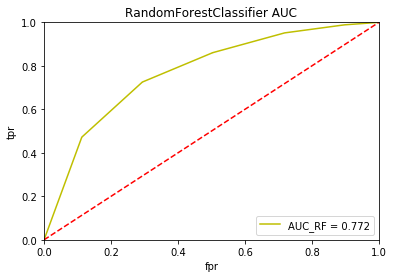

In [33]:
from sklearn.metrics import classification_report
from sklearn import metrics

# 预测
print("精确率和召回率（随机森林）：", classification_report(y_test, rf.predict(x_test), labels=[0, 1], target_names=["普通玩家", "RMB玩家"]))
pre_score = rf.score(x_test, y_test)
print("准确率（随机森林）：{}".format(pre_score))
# 输出概率
predictions = rf.predict_proba(x_test)
# 计算auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions[:, 1])
auc_value = metrics.auc(fpr, tpr)
print("auc值为：{}".format(auc_value))
# 绘图
plt.title('RandomForestClassifier AUC')
plt.plot(fpr, tpr, 'y', label='AUC_RF = %0.3f' % auc_value)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.savefig(os.path.join(base_dir, "count_auc.png"))

## 12. 随机森林回归

In [ ]:
# 选出分类后的数据
# 过滤分类后预测45天后有充钱的玩家
# 

In [39]:
from sklearn.ensemble import RandomForestRegressor

rr = RandomForestRegressor(n_estimators=100)  # 使用100个决策树
rr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rr_y_predict = rr.predict(x_test)

print(rr_y_predict)

# The mean squared error
print("Root Mean squared error: %.2f"
      % mean_squared_error(y_test, rr_y_predict) ** 0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rr_y_predict))

[1.   0.7  0.96 ... 0.59 0.49 0.9 ]
Root Mean squared error: 0.37
Variance score: 0.30
